Tratar CSV

In [17]:
import datetime
import pandas as pd
import re
from datetime import datetime, timedelta

def corrigir_diferenca_tempo(dataframe):
    dataframe['datetime'] = pd.to_datetime(dataframe['time'], unit='s')

    time_diff = dataframe['datetime'].diff()
    time_diff = time_diff.fillna(pd.Timedelta(seconds=0))
    time_diff = time_diff.apply(lambda x: pd.Timedelta(minutes=1) if x.total_seconds() == 1 else x)

    dataframe['datetime'] = dataframe['datetime'] + time_diff.cumsum()

    dataframe['datetime'] = dataframe['datetime'].apply(lambda dt: dt.replace(second=0))
    
    return dataframe

def timestamp_para_datahora(timestamp):
    datahora = datetime.datetime.fromtimestamp(timestamp)
    return datahora

def merge_dataframe(df, group_size=60):
    # Cria o dataframe auxiliar
    df_merged = pd.DataFrame()

    # Loop pelos grupos de tamanho "group_size"
    for i in range(0, len(df), group_size):
        # Seleciona o grupo atual
        df_group = df.iloc[i:i+group_size,:]

        # Loop pelas colunas do grupo
        for col in df_group.columns:

            # Verifica se a coluna é a datetime
            if col == 'datetime':
                # Armazena o valor da primeira linha da coluna
                col_value = df_group[col].iloc[0]

                # Ajusta apenas a hora mantendo os minutos
                col_value = col_value.replace(minute=0, second=0)

            else:
                # Armazena o valor da primeira linha da coluna
                col_value = df_group[col].iloc[0]

                # Loop pelas linhas da coluna
                for j in range(1, len(df_group)):

                    # Verifica se o valor atual é maior ou menor que o valor armazenado
                    if df_group[col].iloc[j] > col_value:
                        # Soma a diferença na variável armazenada
                        col_value += df_group[col].iloc[j] - col_value
                        
                    elif df_group[col].iloc[j] < col_value:
                        # Soma a diferença na variável armazenada
                        col_value -= col_value - df_group[col].iloc[j]

            # Insere a coluna e valor no dataframe auxiliar
            df_merged.loc[i//group_size, col] = col_value

    return df_merged

def encontrar_valor_em_dataframe(dataframe, valor):
    mask = dataframe['datetime'] == valor
    if mask.any():
        row = mask.idxmax()
        return row
    else:
        return None

def subtrair_uma_hora(valor):
    formato = '%Y-%m-%d %H:%M:%S'
    data_hora = datetime.strptime(valor, formato)
    nova_data_hora = data_hora - timedelta(hours=1)
    return nova_data_hora.strftime(formato)

def subtrair_uma_semana(valor):
    formato = '%Y-%m-%d %H:%M:%S'
    data_hora = datetime.strptime(valor, formato)
    nova_data_hora = data_hora - timedelta(weeks=1)
    return nova_data_hora.strftime(formato)

def somar_uma_semana(valor):
    formato = '%Y-%m-%d %H:%M:%S'
    data_hora = datetime.strptime(valor, formato)
    nova_data_hora = data_hora + timedelta(weeks=1)
    return nova_data_hora.strftime(formato)

def formatar_dataframeSemMerge(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Converter a coluna "time" para valores numéricos e filtrar os valores nulos e não numéricos
    dataframe['time'] = pd.to_numeric(dataframe['time'], errors='coerce')
    dataframe = dataframe[~dataframe['time'].isna()]

    # Converter a coluna "time" para timestamp e criar a coluna "datetime"
    dataframe = corrigir_diferenca_tempo(dataframe)

    # Apagar a coluna "time", "summary", "icon", "cloudCover"
    dataframe = dataframe.drop(columns=['time', 'summary', 'icon', 'cloudCover'])

    # Ordena alfabeticamente as colunas
    dataframe = dataframe.sort_index(axis=1)

    return dataframe

def formatar_dataframe(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Converter a coluna "time" para valores numéricos e filtrar os valores nulos e não numéricos
    dataframe['time'] = pd.to_numeric(dataframe['time'], errors='coerce')
    dataframe = dataframe[~dataframe['time'].isna()]

    # Converter a coluna "time" para timestamp e criar a coluna "datetime"
    dataframe = corrigir_diferenca_tempo(dataframe)

    # Apagar a coluna "time", "summary", "icon", "cloudCover"
    dataframe = dataframe.drop(columns=['time', 'summary', 'icon', 'cloudCover'])

    # Ordena alfabeticamente as colunas
    dataframe = dataframe.sort_index(axis=1)

    return merge_dataframe(dataframe)

Salvar CSV Tratado

In [18]:
import pandas as pd

filepath = '../Files/HomeCTratado.csv'
dataframe = formatar_dataframe(pd.read_csv('../Files/HomeC.csv', delimiter=',', low_memory=False))

dataframe.to_csv(filepath, index=False)

KeyboardInterrupt: 

Treinar modelo

In [1]:
from sklearn.ensemble import IsolationForest
import pandas as pd

#Abrir CSV ja tratado
df = pd.read_csv('../Files/HomeCTratado.csv', delimiter=',', low_memory=False)

#Colunas que não envolvem KW
exclude_columns = ['apparentTemperature','datetime','dewPoint','humidity','precipIntensity','precipProbability','pressure','temperature','visibility','windBearing','windSpeed']

#Salvar todos os dados do dataframe menos as colunas acima
X = df[[column for column in list(df.columns) if column not in exclude_columns]]

#Definir padrões pro algoritmo
isolation_forest = IsolationForest(n_estimators=100, contamination='auto')

#Treinar o algoritmo
isolation_forest.fit(X)

#Achar as anomalias
y_pred = isolation_forest.predict(X)

#Adicionar nova coluna dizendo se é ou não anomalia
df['anomaly'] = y_pred

#Dataframe somente com anomalias
anomaly = df.loc[df['anomaly'] == -1]

anomaly

,Barn [kW],Dishwasher [kW],Fridge [kW],Furnace 1 [kW],Furnace 2 [kW],Garage door [kW],Home office [kW],House overall [kW],Kitchen 12 [kW],Kitchen 14 [kW],...,humidity,precipIntensity,precipProbability,pressure,temperature,use [kW],visibility,windBearing,windSpeed,anomaly
13,0.029000,0.000067,0.110217,0.436733,0.631117,0.012650,0.041317,1.908850,0.000517,0.045500,...,0.58,0.0,0.0,1012.71,37.19,1.908850,10.00,268.0,7.61,-1
18,0.035883,0.000050,0.593800,0.486150,0.658983,0.012333,0.041833,5.359650,0.000617,0.000650,...,0.70,0.0,0.0,1013.62,32.87,5.359650,8.06,273.0,9.14,-1
23,0.034200,1.231283,0.136100,0.492267,0.680150,0.011467,0.051483,2.908333,0.000467,0.000833,...,0.60,0.0,0.0,1014.19,30.04,2.908333,10.00,275.0,8.02,-1
24,0.034550,1.366750,0.003850,0.493400,0.071683,0.011017,0.051950,2.094050,0.000933,0.001317,...,0.60,0.0,0.0,1014.24,29.56,2.094050,10.00,273.0,8.04,-1
31,0.030933,0.000067,0.021033,0.458117,0.651883,0.012633,0.048750,1.945383,0.000517,0.000150,...,0.56,0.0,0.0,1016.09,30.79,1.945383,10.00,254.0,7.97,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8293,0.028750,0.000250,0.004733,0.500533,0.064083,0.012083,0.040217,2.167317,0.000867,0.000300,...,0.56,0.0,0.0,1042.44,21.49,2.167317,10.00,25.0,5.02,-1
8322,0.031717,0.000017,0.018217,0.243667,0.606250,0.013083,0.041900,3.699633,0.000533,0.000050,...,0.55,0.0,0.0,1008.94,44.25,3.699633,10.00,308.0,14.71,-1
8335,0.029150,0.000217,0.004650,0.439733,0.063750,0.012283,0.040250,2.590267,0.000733,0.000350,...,0.68,0.0,0.0,1014.94,33.92,2.590267,9.94,291.0,9.58,-1
8375,0.032017,0.119467,0.135683,0.496117,0.063383,0.012183,0.042617,2.735383,0.000500,0.000333,...,0.81,0.0,0.0,995.90,32.63,2.735383,9.17,279.0,9.44,-1


In [ ]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

#csv_original = formatar_dataframeSemMerge(pd.read_csv('../FIles/HomeC.csv'))

def AllAnomaliesGraph(tamX: int, proporcao : int, quantidade : int = 0):
    csv_original = formatar_dataframeSemMerge(pd.read_csv('../FIles/HomeC.csv'))
    size = len(csv_original.drop(['datetime','apparentTemperature','dewPoint','humidity','precipIntensity','precipProbability','pressure','temperature','visibility','windBearing','windSpeed'], axis=1).columns)
    total_anomalias = len(anomaly.index)

    if(quantidade == 0):
        quantidade = total_anomalias

    tamanho_grupo = total_anomalias // quantidade
    grupos = [anomaly.index[i:i+tamanho_grupo] for i in range(0, total_anomalias, tamanho_grupo)]
    
    for grupo in grupos:
        plt.figure(figsize=(tamX, size * proporcao))
        start_date = None
        end_date = None

        for i, item in enumerate(grupo):
            a = encontrar_valor_em_dataframe(csv_original, subtrair_uma_hora(anomaly['datetime'][item]))
            b = encontrar_valor_em_dataframe(csv_original, anomaly['datetime'][item])

            if a is not None and b is not None:
                df_temp = csv_original[a:b+1]
                df_temp2 = df_temp.drop(['datetime','apparentTemperature','dewPoint','humidity','precipIntensity','precipProbability','pressure','temperature','visibility','windBearing','windSpeed'], axis=1)
                x = df_temp['datetime']
                t = 0
                for j in df_temp2.columns.tolist():
                    if t < len(df_temp2.columns):
                        y1 = df_temp2[df_temp2.columns[t]]
                        plt.plot(x, y1)
                        t += 1

                if start_date is None:
                    start_date = x[a]  # Armazena o valor de x[a] para o primeiro item do grupo

                end_date = x[b]  # Atualiza o valor de x[b] para cada item do grupo, até o último

                plt.xlabel('data')
                plt.ylabel('KW')

        plt.title('Intervalo de tempo de anomalia registrados de ' + str(start_date) + ' até ' + str(end_date))
        plt.legend(df_temp2.columns.tolist())  # Adiciona a legenda fora do loop interno
        plt.show()




def KwUsageGraph():
    csv_original = formatar_dataframeSemMerge(pd.read_csv('../FIles/HomeC.csv'))

    a = encontrar_valor_em_dataframe(csv_original,subtrair_uma_hora(anomaly['datetime'][18]))
    b = encontrar_valor_em_dataframe(csv_original,anomaly['datetime'][18])
    df_temp = csv_original[a:b+1]
    df_temp2 = pd.DataFrame({'use [kW]': df_temp.pop('use [kW]')})
    x = df_temp['datetime']
    y1 = df_temp2[df_temp2.columns[0]]
    
    fig, ax = plt.subplots(figsize=(30, 10))  # Ajuste o tamanho da figura conforme necessário
    ax.plot(x, y1, label=df_temp2.columns[0])
    
    # Configurar rótulos do eixo x
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    plt.xticks(rotation=45, ha='right')  # Rotação de 45 graus para evitar sobreposições
    
    # Configurar rótulos do eixo y
    #ax.yaxis.set_major_locator(plt.MaxNLocator(10))  # Intervalo aproximado de 10 rótulos no eixo Y
    
    plt.title('Intervalo de tempo de anomalia registrados de ' + str(x[a]) + ' até ' + str(x[b]))
    plt.xlabel('Data')
    plt.ylabel('KW')
    plt.legend()
    plt.tight_layout()  # Ajusta o espaçamento para evitar cortes no gráfico
    plt.show()

AllAnomaliesGraph(27, 0.5)
#KwUsageGraph()

Todas as funções:

Usar esse pra debugar, quando corrigir um bug, colar no MachineLearning.py

In [9]:
from sklearn.ensemble import IsolationForest
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

def corrigir_diferenca_tempo(dataframe):
    dataframe['datetime'] = pd.to_datetime(dataframe['time'], unit='s')

    time_diff = dataframe['datetime'].diff()
    time_diff = time_diff.fillna(pd.Timedelta(seconds=0))
    time_diff = time_diff.apply(lambda x: pd.Timedelta(minutes=1) if x.total_seconds() == 1 else x)

    dataframe['datetime'] = dataframe['datetime'] + time_diff.cumsum()

    dataframe['datetime'] = dataframe['datetime'].apply(lambda dt: dt.replace(second=0))
    
    return dataframe

def timestamp_para_datahora(timestamp):
    datahora = datetime.datetime.fromtimestamp(timestamp)
    return datahora

def merge_dataframe(df, group_size=60):
    # Cria o dataframe auxiliar
    df_merged = pd.DataFrame()

    # Loop pelos grupos de tamanho "group_size"
    for i in range(0, len(df), group_size):
        # Seleciona o grupo atual
        df_group = df.iloc[i:i+group_size,:]

        # Loop pelas colunas do grupo
        for col in df_group.columns:

            # Verifica se a coluna é a datetime
            if col == 'datetime':
                # Armazena o valor da primeira linha da coluna
                col_value = df_group[col].iloc[0]

                # Ajusta apenas a hora mantendo os minutos
                col_value = col_value.replace(minute=0, second=0)

            else:
                # Armazena o valor da primeira linha da coluna
                col_value = df_group[col].iloc[0]

                # Loop pelas linhas da coluna
                for j in range(1, len(df_group)):

                    # Verifica se o valor atual é maior ou menor que o valor armazenado
                    if df_group[col].iloc[j] > col_value:
                        # Soma a diferença na variável armazenada
                        col_value += df_group[col].iloc[j] - col_value
                        
                    elif df_group[col].iloc[j] < col_value:
                        # Soma a diferença na variável armazenada
                        col_value -= col_value - df_group[col].iloc[j]

            # Insere a coluna e valor no dataframe auxiliar
            df_merged.loc[i//group_size, col] = col_value

    return df_merged

def encontrar_valor_em_dataframe(dataframe, valor):
    mask = dataframe['datetime'] == valor
    if mask.any():
        row = mask.idxmax()
        return row
    else:
        return None
    
def subtrair_uma_hora(valor):
    formato = '%Y-%m-%d %H:%M:%S'
    data_hora = datetime.strptime(valor, formato)
    nova_data_hora = data_hora - timedelta(hours=1)
    return nova_data_hora.strftime(formato)

def subtrair_uma_semana(valor):
    formato = '%Y-%m-%d %H:%M:%S'
    data_hora = datetime.strptime(valor, formato)
    nova_data_hora = data_hora - timedelta(weeks=1)
    return nova_data_hora.strftime(formato)

def somar_uma_semana(valor):
    formato = '%Y-%m-%d %H:%M:%S'
    data_hora = datetime.strptime(valor, formato)
    nova_data_hora = data_hora + timedelta(weeks=1)
    return nova_data_hora.strftime(formato)

def formatar_dataframeSemMerge(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Converter a coluna "time" para valores numéricos e filtrar os valores nulos e não numéricos
    dataframe['time'] = pd.to_numeric(dataframe['time'], errors='coerce')
    dataframe = dataframe[~dataframe['time'].isna()]

    # Converter a coluna "time" para timestamp e criar a coluna "datetime"
    dataframe = corrigir_diferenca_tempo(dataframe)

    # Apagar a coluna "time", "summary", "icon", "cloudCover"
    dataframe = dataframe.drop(columns=['time', 'summary', 'icon', 'cloudCover'])

    # Ordena alfabeticamente as colunas
    dataframe = dataframe.sort_index(axis=1)

    return dataframe

def formatar_dataframe(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Converter a coluna "time" para valores numéricos e filtrar os valores nulos e não numéricos
    dataframe['time'] = pd.to_numeric(dataframe['time'], errors='coerce')
    dataframe = dataframe[~dataframe['time'].isna()]

    # Converter a coluna "time" para timestamp e criar a coluna "datetime"
    dataframe = corrigir_diferenca_tempo(dataframe)

    # Apagar a coluna "time", "summary", "icon", "cloudCover"
    dataframe = dataframe.drop(columns=['time', 'summary', 'icon', 'cloudCover'])

    # Ordena alfabeticamente as colunas
    dataframe = dataframe.sort_index(axis=1)

    return merge_dataframe(dataframe)

def tratar_dataframe(dataframe):
    dataframe = formatar_dataframe(dataframe)

    return dataframe

def achar_anomalias(dataframe):
    df = tratar_dataframe(dataframe)

    #Colunas que não envolvem KW
    exclude_columns = ['apparentTemperature','datetime','dewPoint','humidity','precipIntensity','precipProbability','pressure','temperature','visibility','windBearing','windSpeed']

    #Salvar todos os dados do dataframe menos as colunas acima
    X = df[[column for column in list(df.columns) if column not in exclude_columns]]

    #Salvar todos os dados do dataframe menos as colunas acima
    X = df[[column for column in list(df.columns) if column not in exclude_columns]]

    #Definir padrões pro algoritmo
    isolation_forest = IsolationForest(n_estimators=100, contamination='auto')

    #Treinar o algoritmo
    isolation_forest.fit(X)

    #Achar as anomalias
    y_pred = isolation_forest.predict(X)

    #Adicionar nova coluna dizendo se é ou não anomalia
    df['anomaly'] = y_pred

    #Dataframe somente com anomalias
    anomaly = df.loc[df['anomaly'] == -1]

    return anomaly

def criar_grafico_e_tabela(csv):
    dataframe = pd.read_csv(csv, delimiter=',', low_memory=False)
    anomalias = achar_anomalias(dataframe)
    graficos = AllAnomaliesGraph(dataframe, anomalias, 27, 0.5, 10)

    return {
        'anomalias' : anomalias,
        'graficos' : graficos
    }

def AllAnomaliesGraph(dataframe, anomaly, tamX: int, proporcao: int, quantidade: int = 0):
    csv_original = formatar_dataframeSemMerge(dataframe)
    size = len(csv_original.drop(['datetime','apparentTemperature','dewPoint','humidity','precipIntensity','precipProbability','pressure','temperature','visibility','windBearing','windSpeed'], axis=1).columns)
    total_anomalias = len(anomaly.index)

    if quantidade == 0:
        quantidade = total_anomalias

    tamanho_grupo = total_anomalias // quantidade
    grupos = [anomaly.index[i:i+tamanho_grupo] for i in range(0, total_anomalias, tamanho_grupo)]

    plots = []

    for grupo in grupos:
        fig, ax = plt.subplots(figsize=(tamX, size * proporcao))
        start_date = None
        end_date = None

        for i, item in enumerate(grupo):
            a = encontrar_valor_em_dataframe(csv_original, subtrair_uma_hora(anomaly['datetime'][item]))
            b = encontrar_valor_em_dataframe(csv_original, anomaly['datetime'][item])

            if a is not None and b is not None:
                df_temp = csv_original[a:b+1]
                df_temp2 = df_temp.drop(['datetime','apparentTemperature','dewPoint','humidity','precipIntensity','precipProbability','pressure','temperature','visibility','windBearing','windSpeed'], axis=1)
                x = df_temp['datetime']
                t = 0
                for j in df_temp2.columns.tolist():
                    if t < len(df_temp2.columns):
                        y1 = df_temp2[df_temp2.columns[t]]
                        ax.plot(x, y1)
                        t += 1

                if start_date is None:
                    start_date = x[a]  # Armazena o valor de x[a] para o primeiro item do grupo

                end_date = x[b]  # Atualiza o valor de x[b] para cada item do grupo, até o último

                ax.set_xlabel('data')
                ax.set_ylabel('KW')

        ax.set_title('Intervalo de tempo de anomalia registrados de ' + str(start_date) + ' até ' + str(end_date))
        ax.legend(df_temp2.columns.tolist())  # Adiciona a legenda fora do loop interno
        plots.append(fig)

    return plots


C:\Users\Alan-\AppData\Local\Temp\ipykernel_20180\2083505517.py:172: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_original = formatar_dataframeSemMerge(pd.read_csv('../FIles/HomeC.csv')) #CONSERTAR
C:\Users\Alan-\AppData\Local\Temp\ipykernel_20180\2083505517.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['datetime'] = pd.to_datetime(dataframe['time'], unit='s')
C:\Users\Alan-\AppData\Local\Temp\ipykernel_20180\2083505517.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

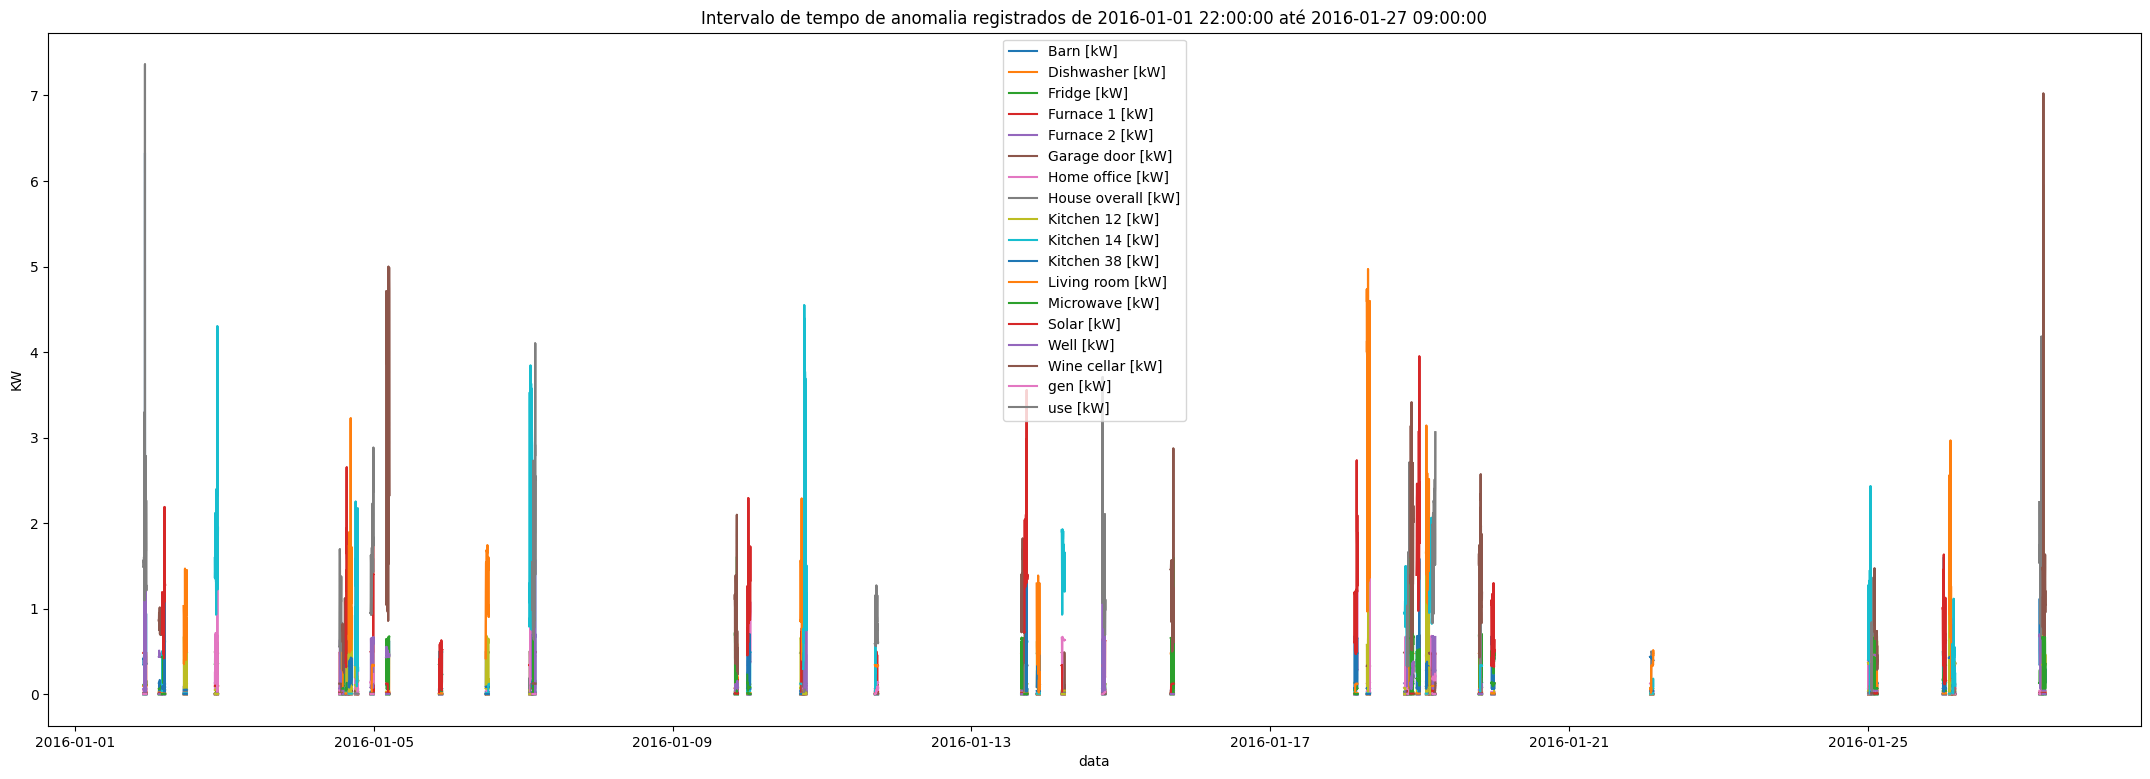

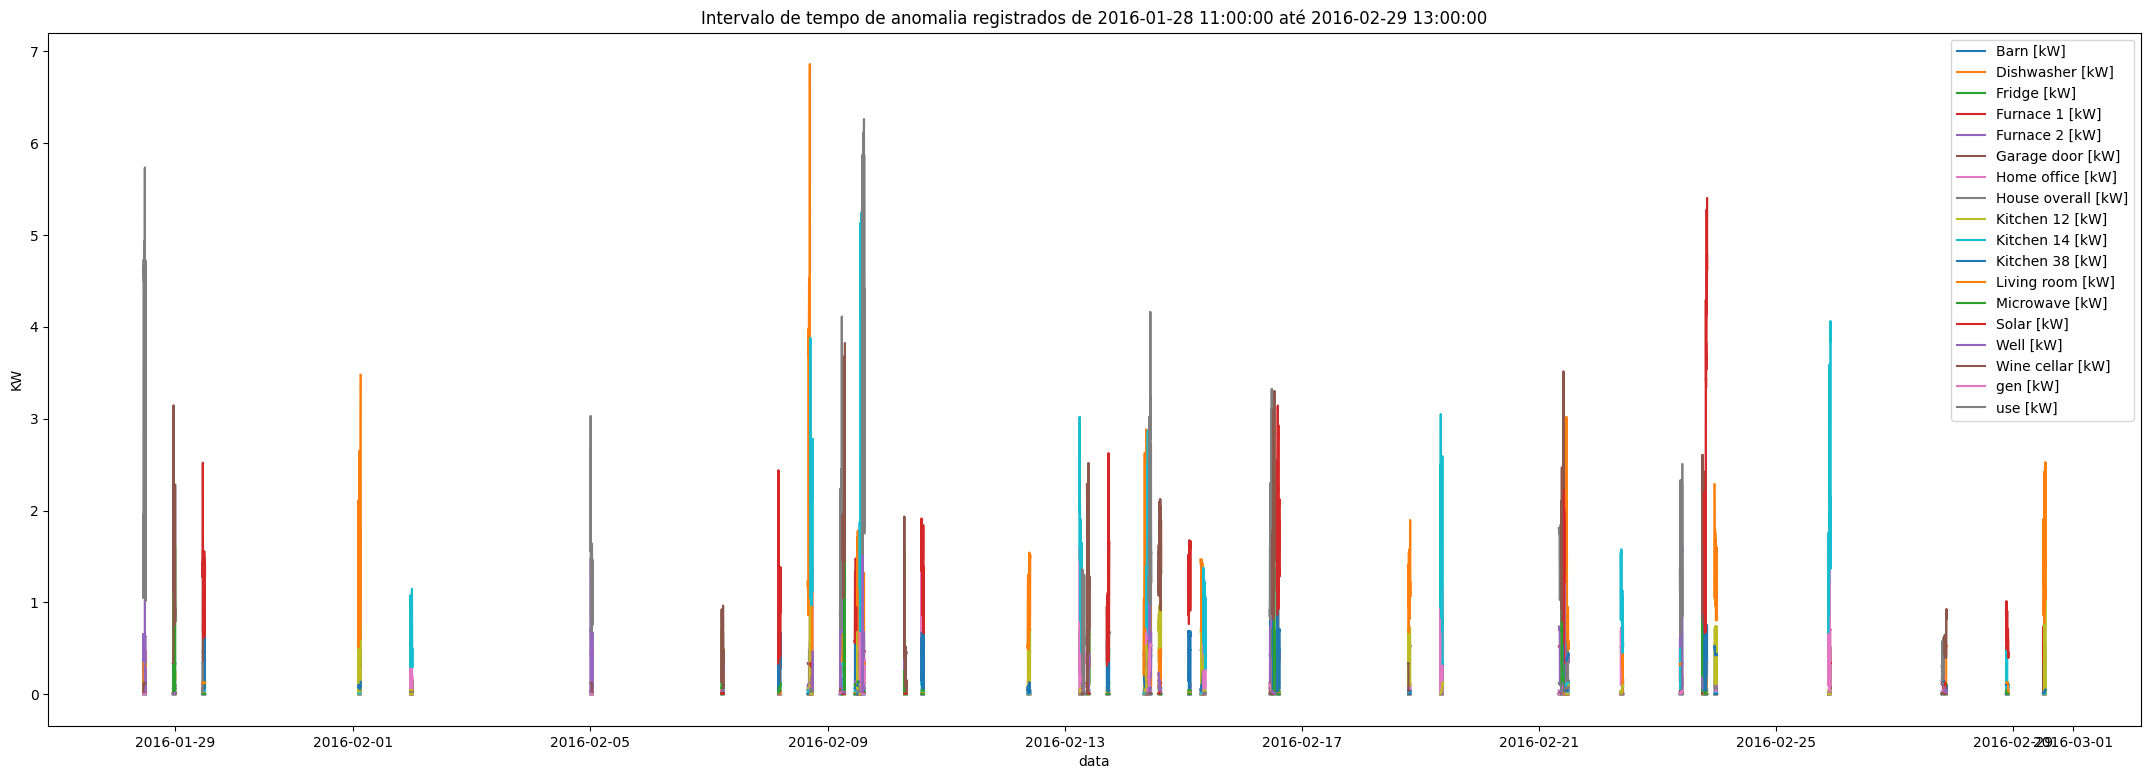

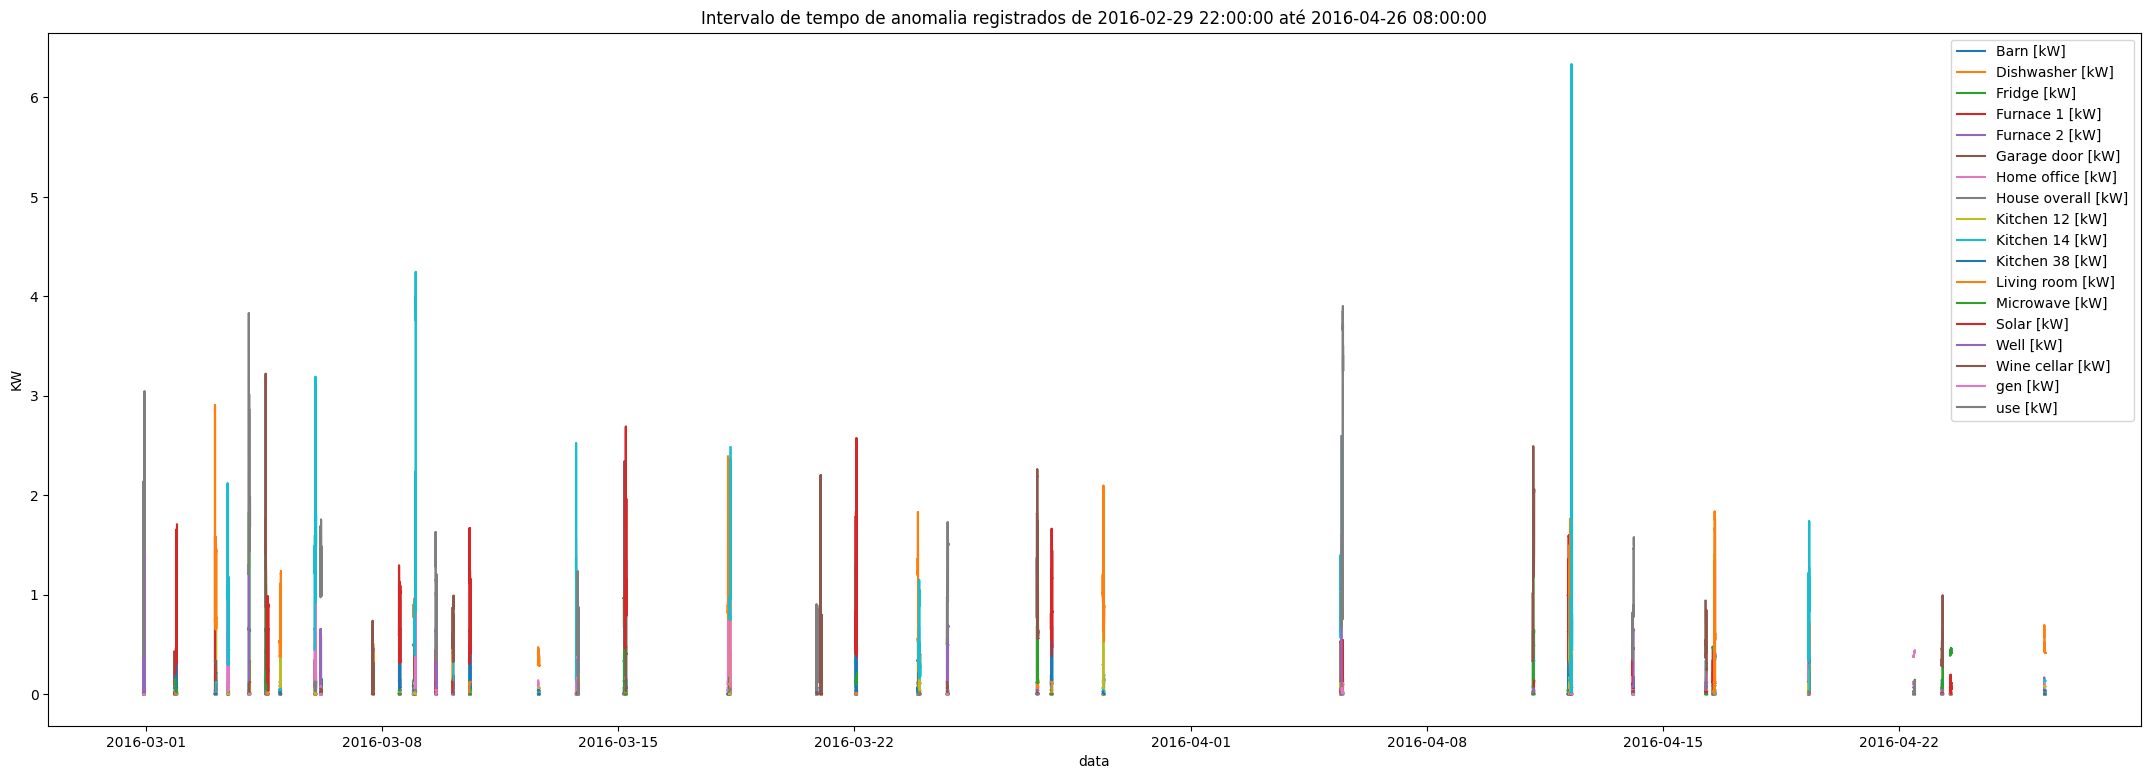

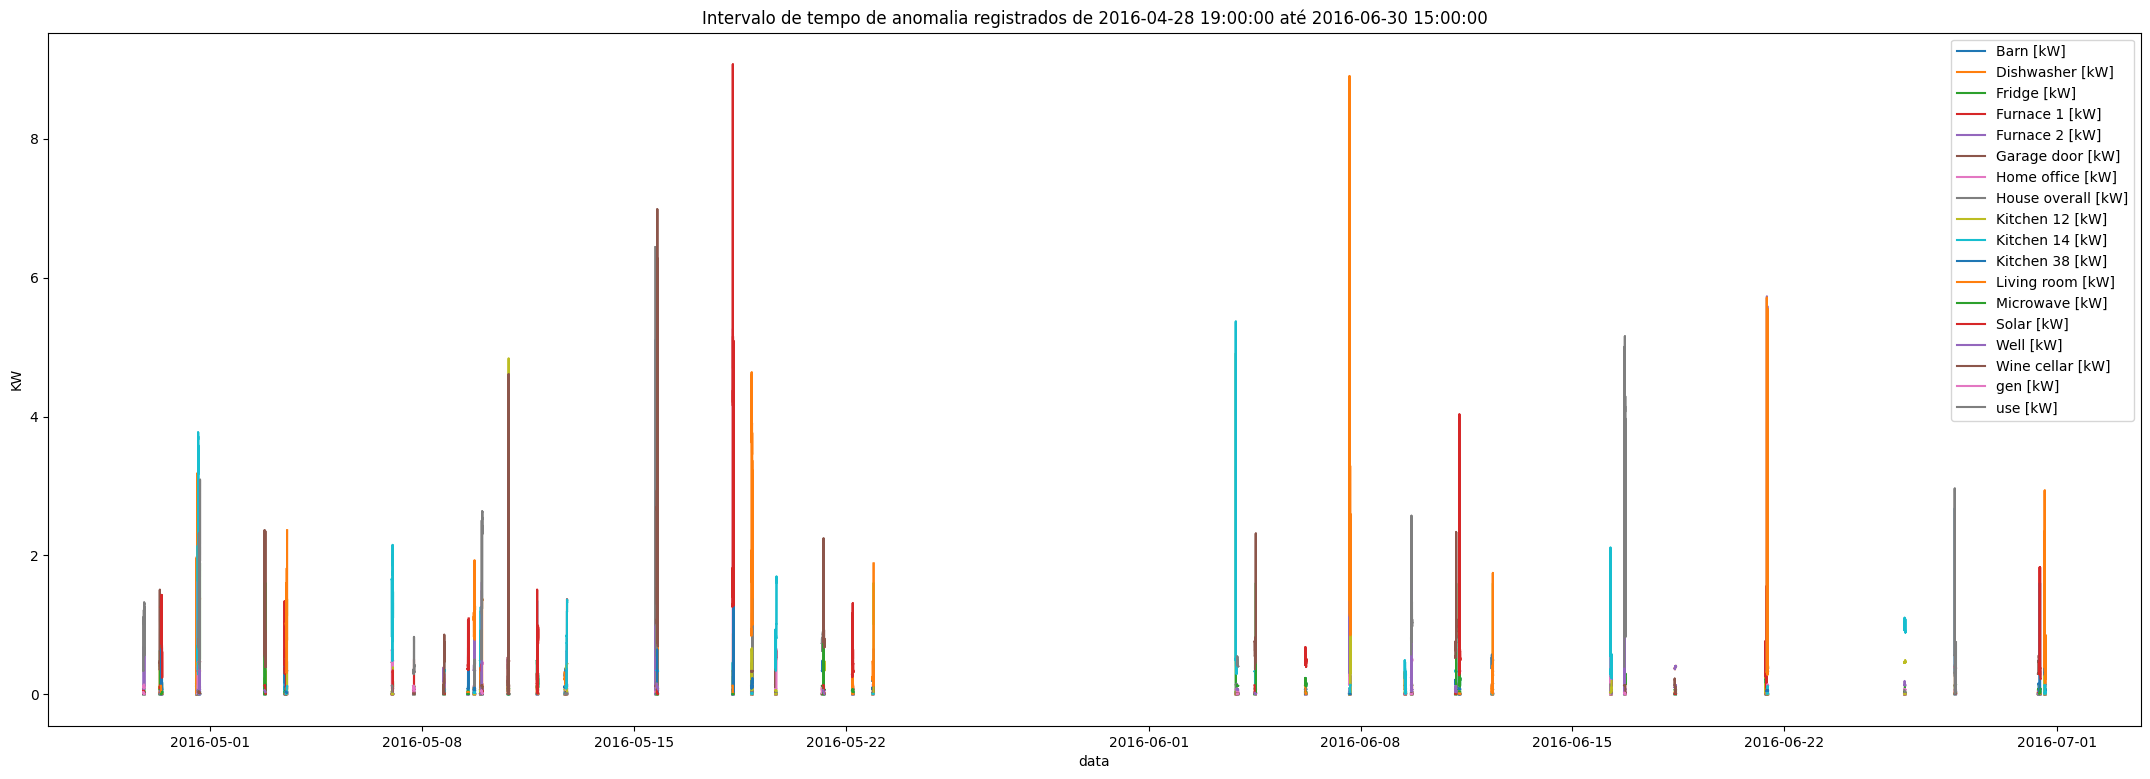

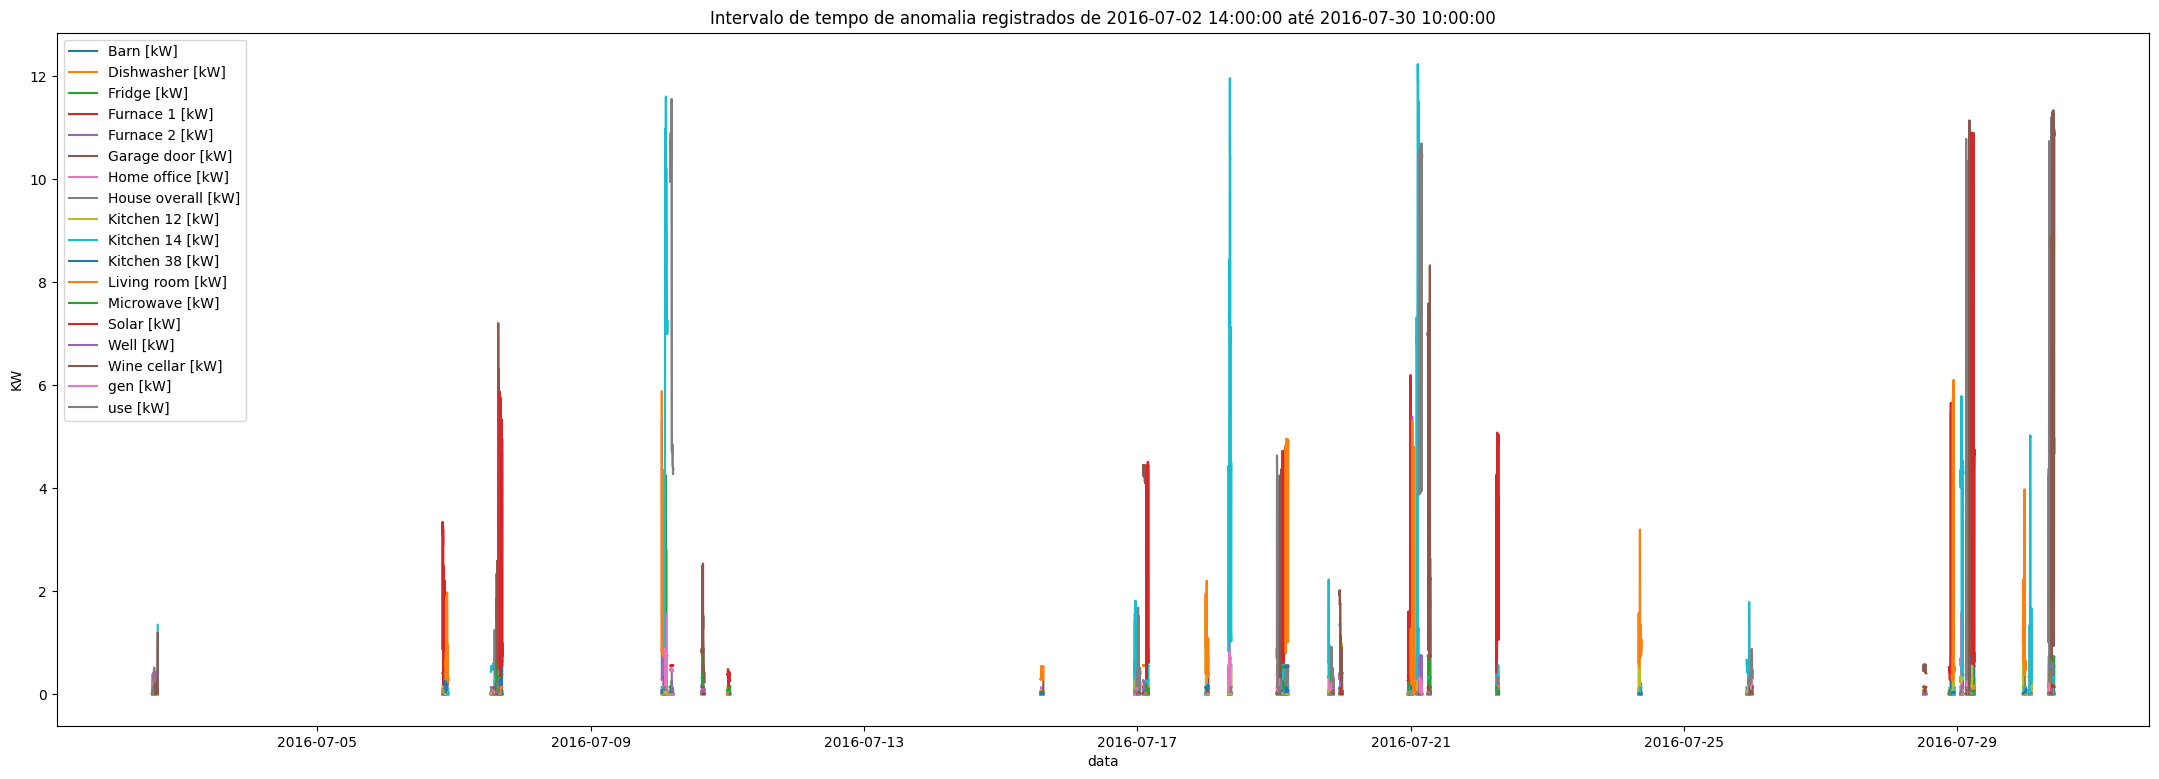

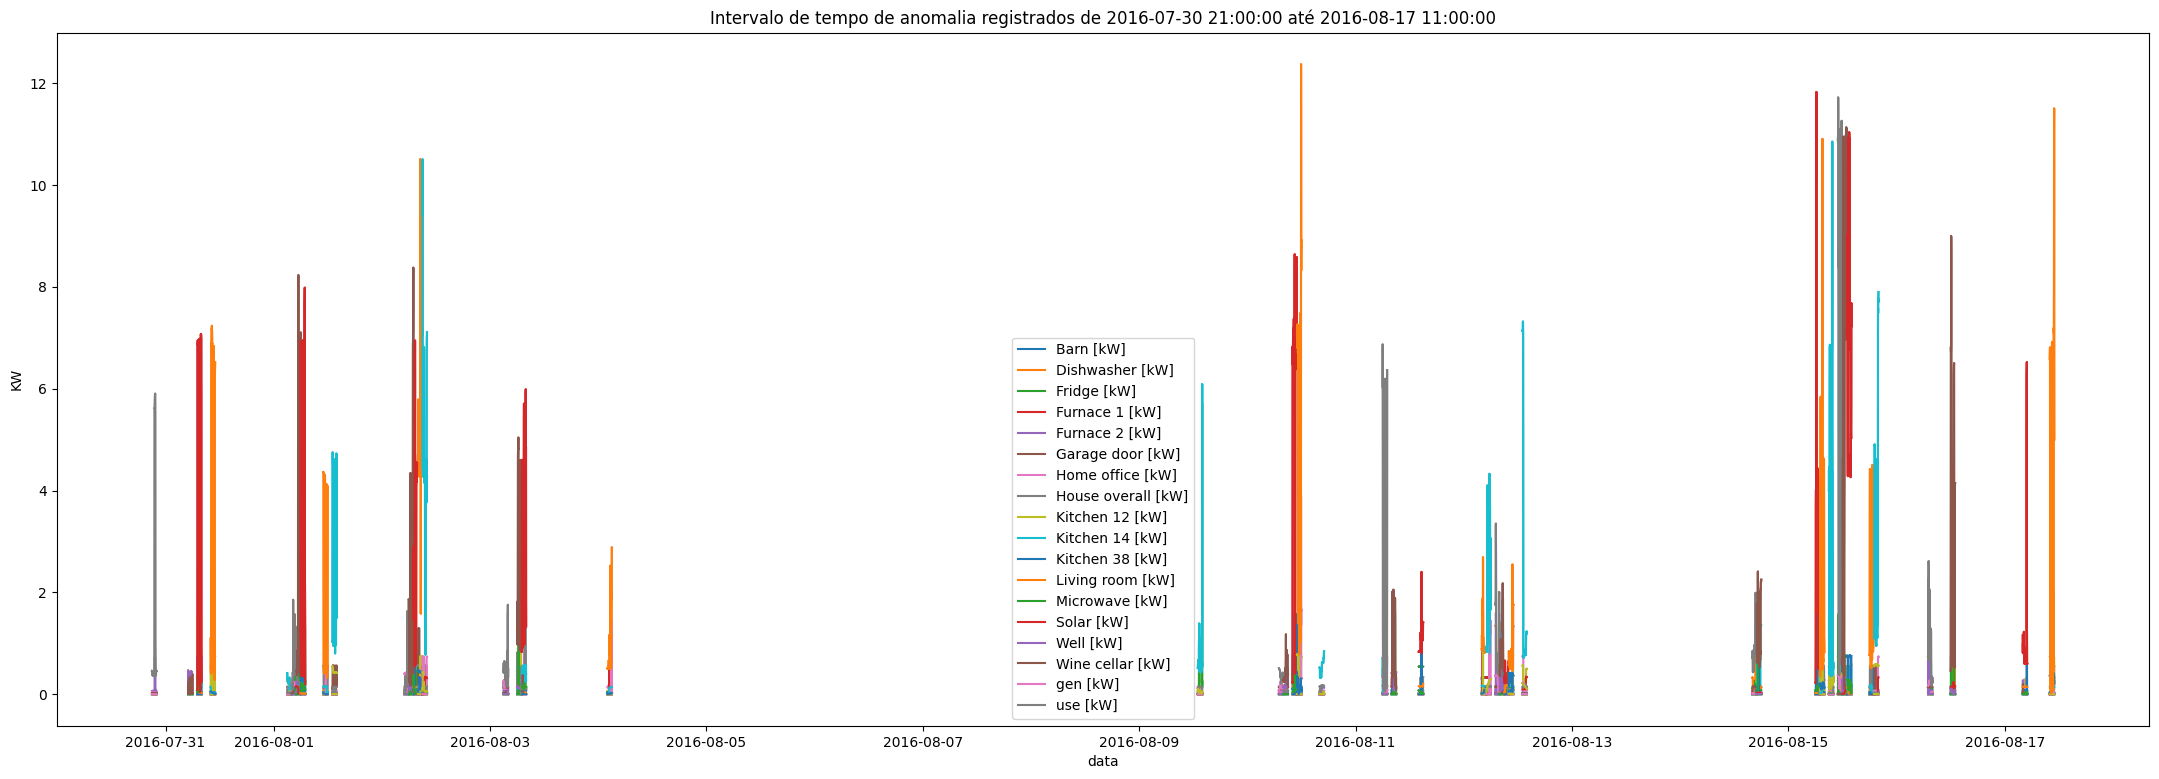

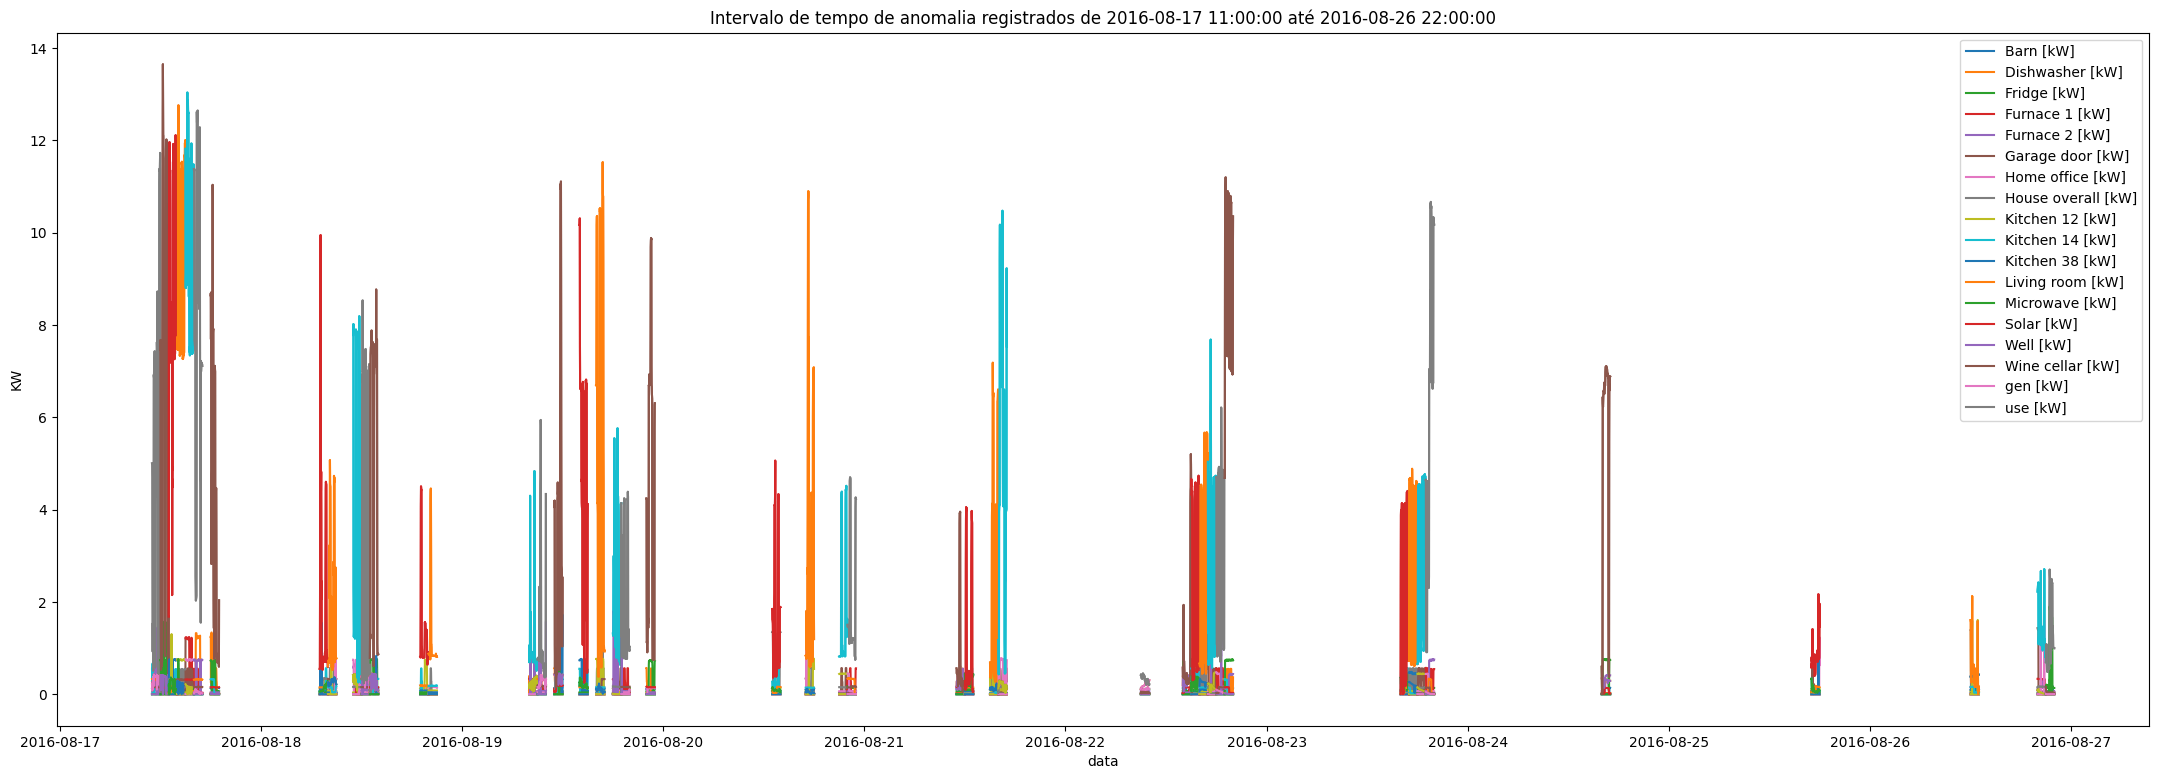

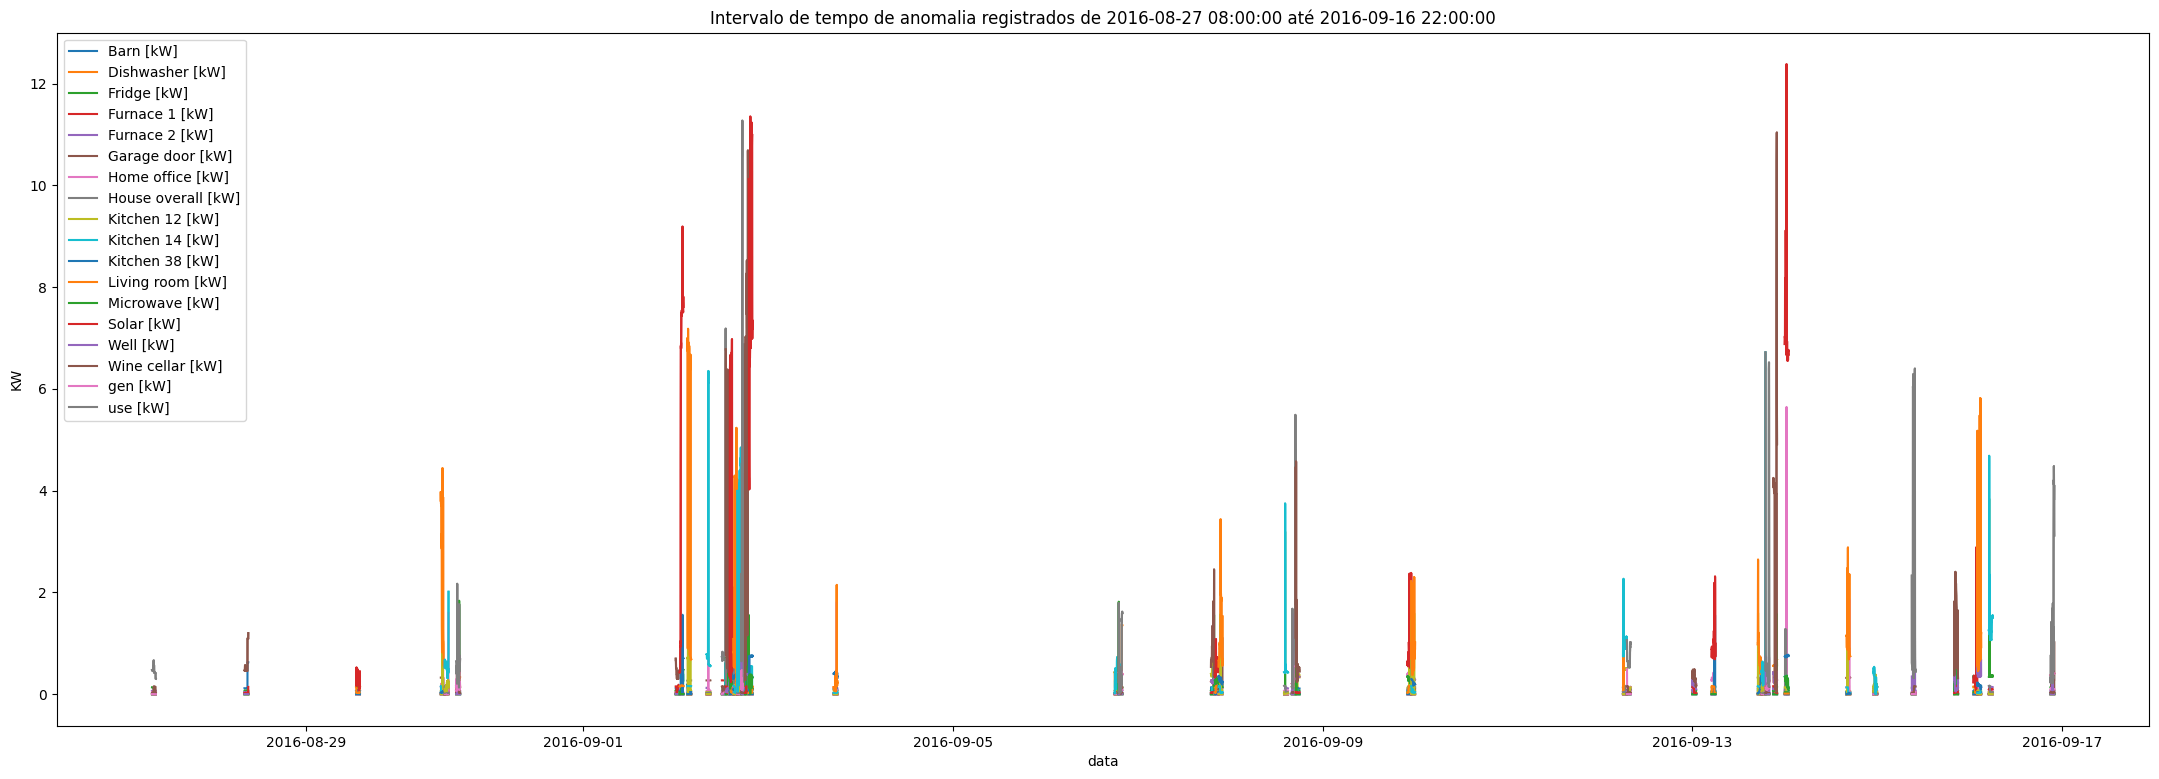

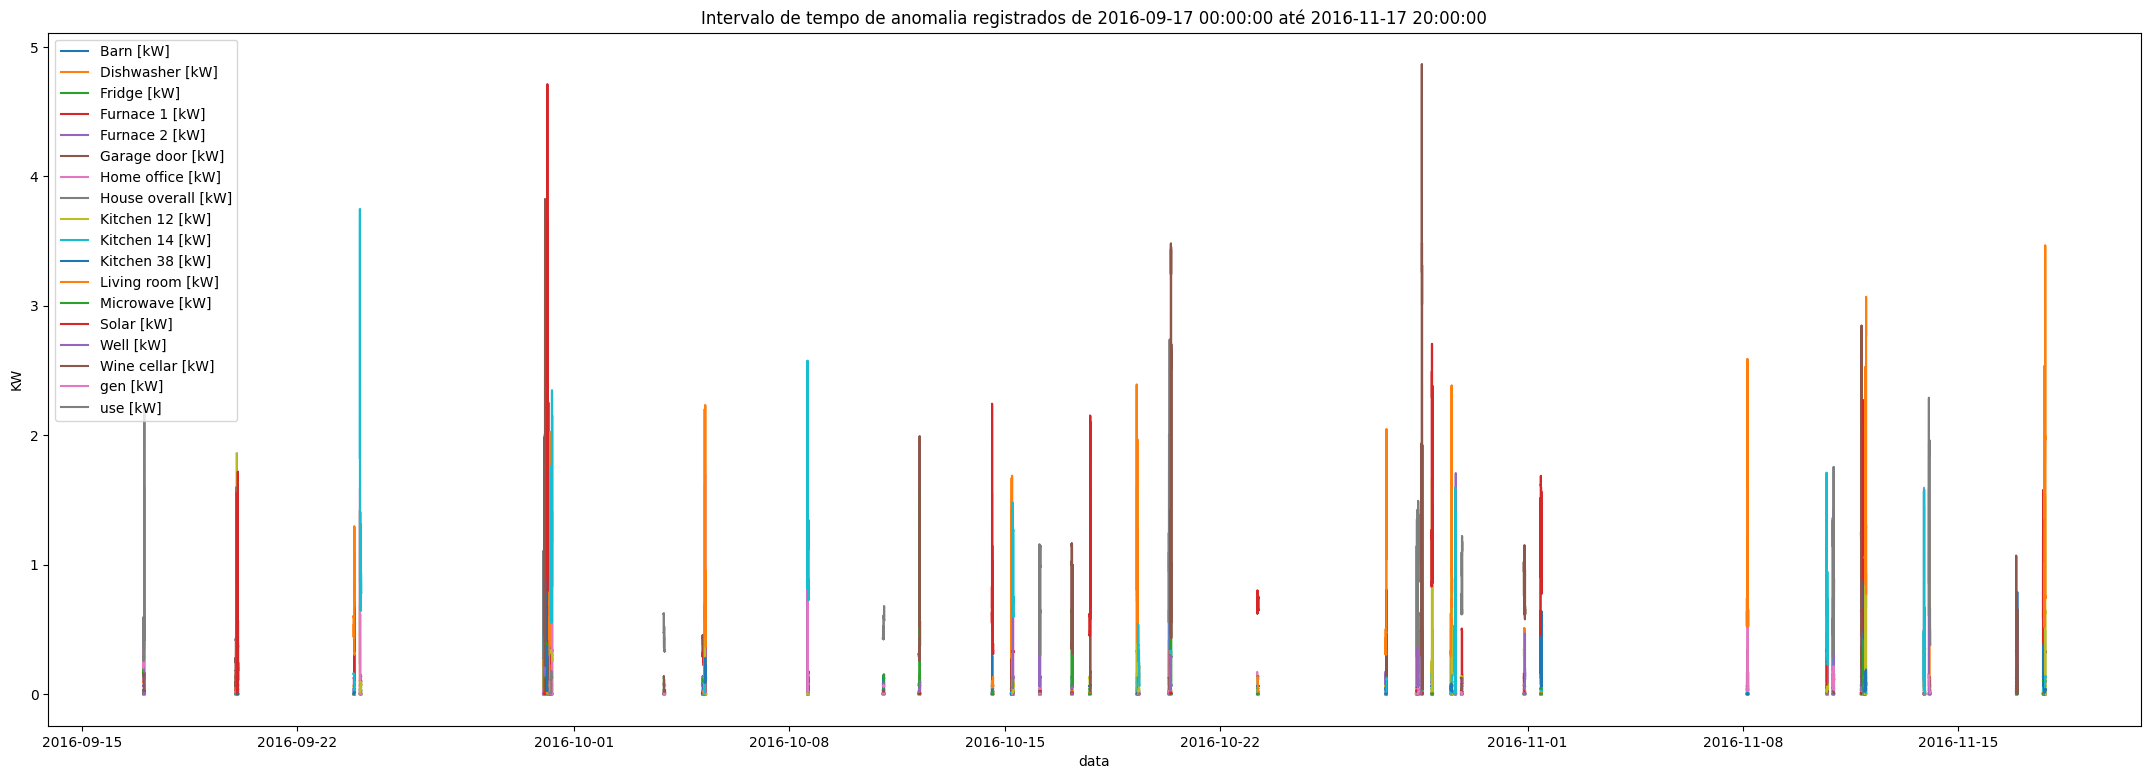

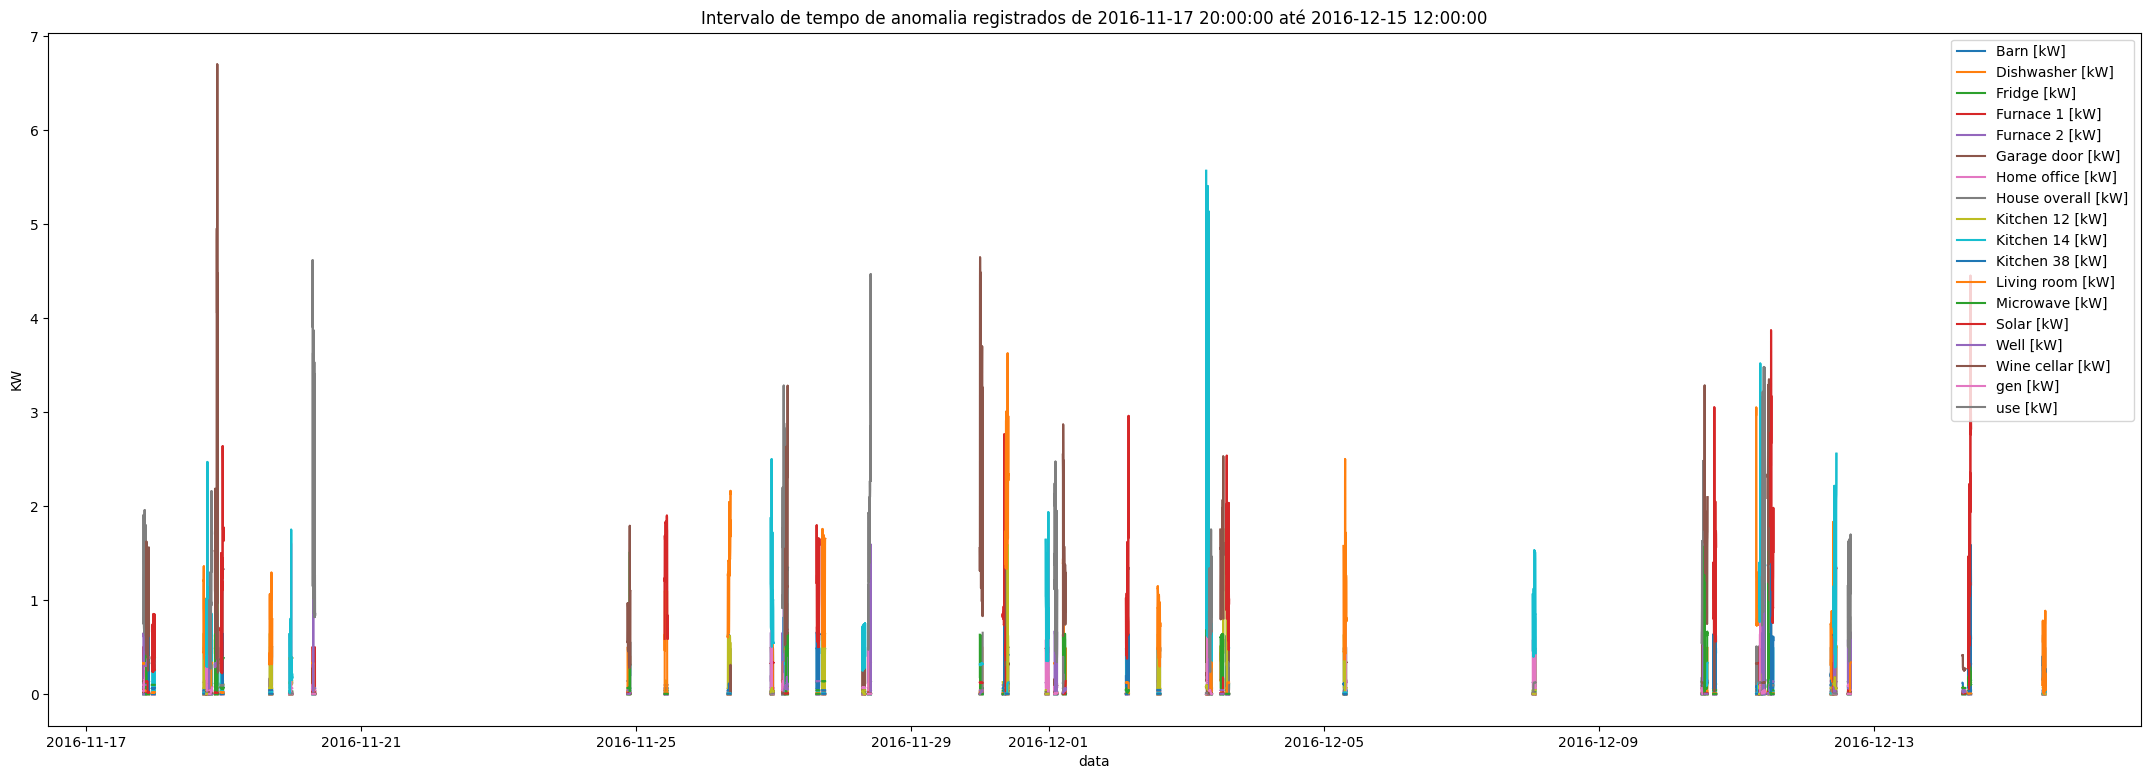

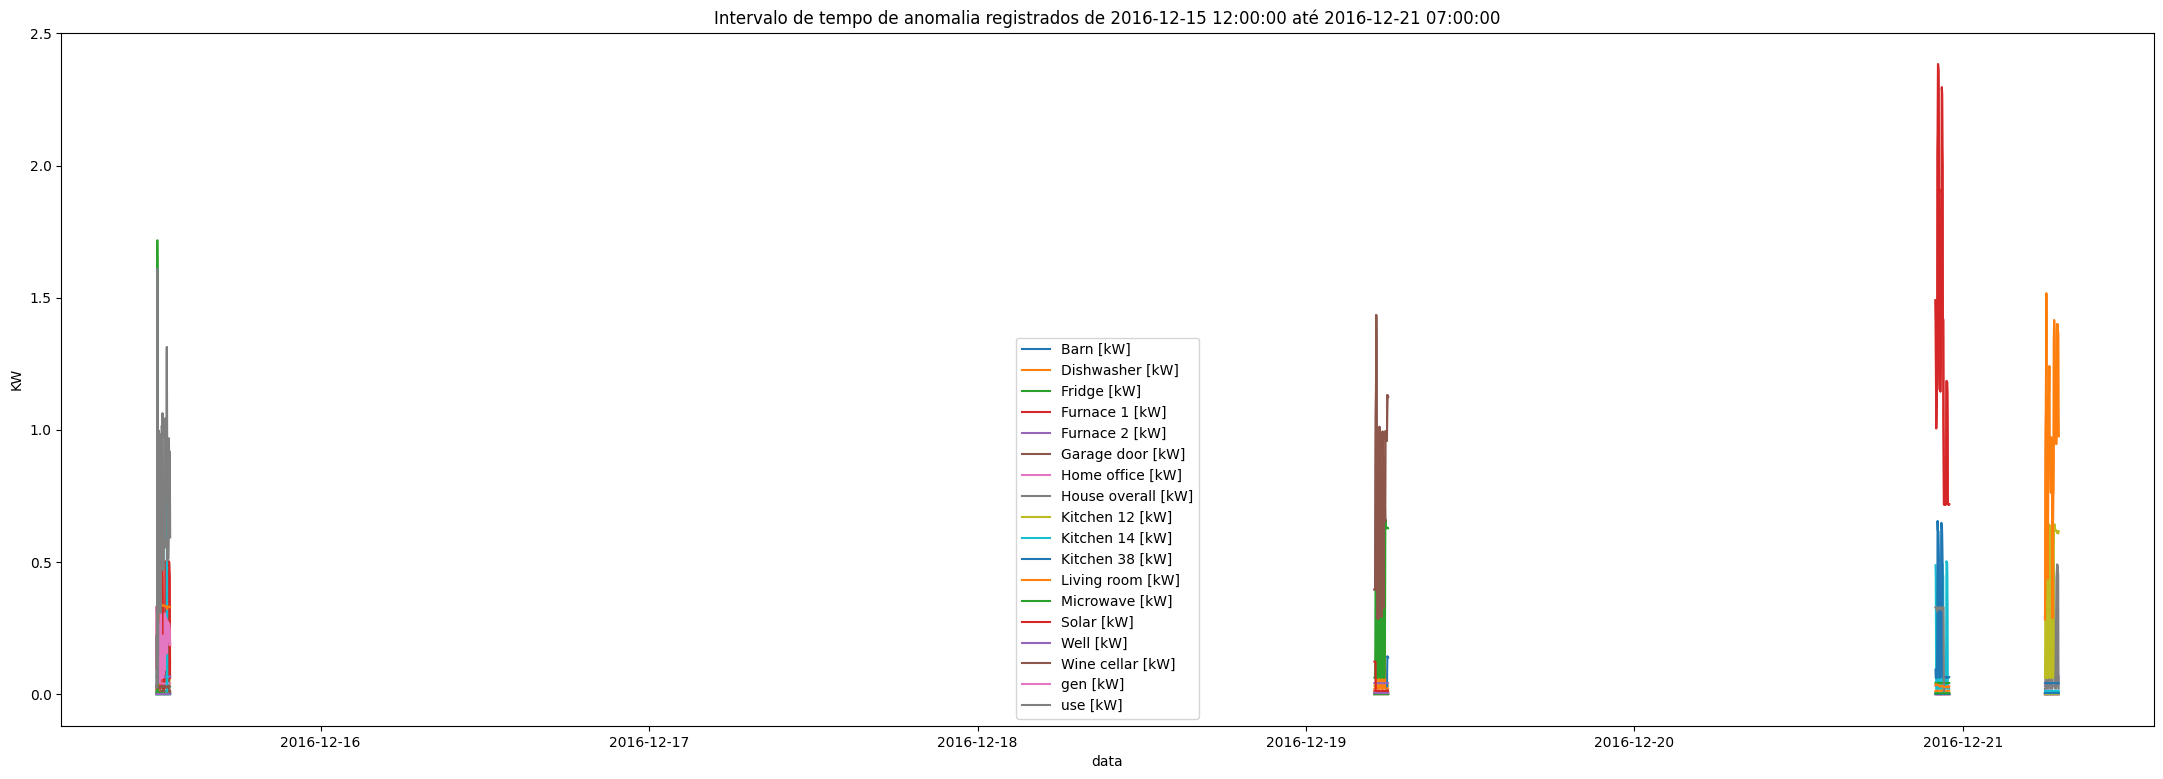

In [10]:
teste = criar_grafico_e_tabela('../Files/HomeC.csv')